In [130]:
import re
import random
import pandas as pd
import hashlib

In [131]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [132]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,77.249202,19.312300,23.632728,4
Django,772.627661,19.315692,35.502907,40
Node.js and Vite,831.933291,20.291056,33.956458,41
Azure Files Documentation,1942.611166,32.376853,114.154540,60
FSLogix,105.074581,35.024860,40.162191,3
Active Directory and Azure Files,1493.000985,40.351378,81.069801,37
CCH Tax Forms Project,874.089740,41.623321,105.848285,21
Python + Oauth2.0,1181.482571,51.368807,122.707571,23
Accounting,874.912109,51.465418,114.129795,17
pfSense,657.178032,54.764836,139.770925,12


# Histogram

sum of ages: ~50173.77


<Axes: >

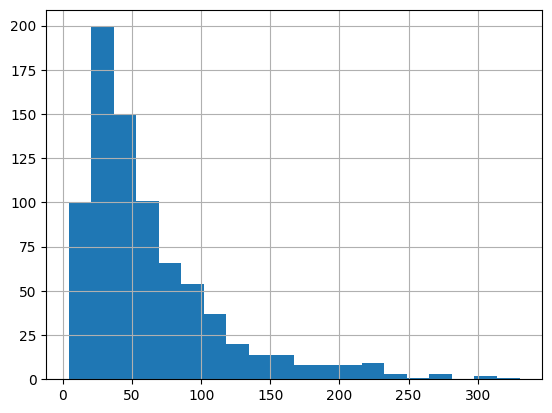

In [133]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50173.77


<Axes: >

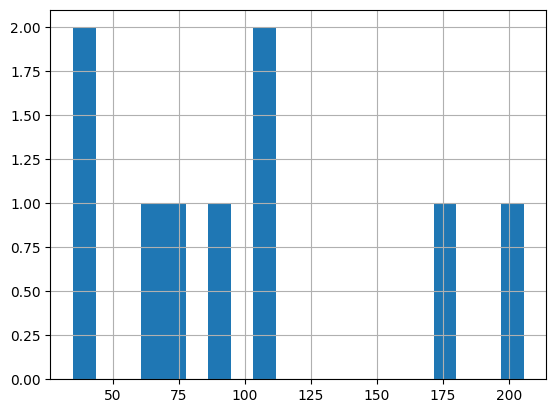

In [134]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [135]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [136]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [137]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 798
Total card age: 50173.77


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
106,JavaScript Concepts,"A LIFO (Last-In, First-Out) stack is a way of ...",177fe59b3fb370453b5cd806c1c92ef3,-248.270734,77.779322,248.270734,-4822.317973,0.565303,62,0,0
109,JavaScript Concepts,Server-Side Rendering (SSR): Rendering web pag...,c5e48c70e1f6a94fffebeac4f977b3d9,-187.412221,77.779322,248.270734,-4822.317973,0.565303,62,3,0
228,JavaScript Concepts,Callback\nA function passed as an argument to ...,9b3cd917f72d441abfeee7a79c32a076,-164.193103,77.779322,248.270734,-4822.317973,0.565303,62,6,0
230,JavaScript Concepts,"For arrays, the String function will apply the...",a077358f760f015696da136b77f4dbb2,-117.698556,77.779322,248.270734,-4822.317973,0.565303,62,9,0
334,JavaScript Concepts,Component-Based Architecture: Building applica...,1d7f416623c5e40d088d712607cc7782,-105.799637,77.779322,248.270734,-4822.317973,0.565303,62,12,0
432,JavaScript Concepts,Context API: A React feature that provides a w...,3c0bb362af8fbf4caac63a60f6d50281,-101.524607,77.779322,248.270734,-4822.317973,0.565303,62,15,0
513,JavaScript Concepts,MDN Web Docs: Comprehensive documentation for ...,c9287adef7e8df34cc143517f912d8d9,-88.930645,77.779322,248.270734,-4822.317973,0.565303,62,18,0
435,JavaScript Concepts,If the addition operator + is used for primiti...,9cb500afa3eac8e680fbc3cd173ada6b,-84.642931,77.779322,248.270734,-4822.317973,0.565303,62,21,0
577,JavaScript Concepts,npm (Node Package Manager): The default packag...,8f845193449c5ca806e72181f96c472f,-68.097893,77.779322,248.270734,-4822.317973,0.565303,62,24,0
579,JavaScript Concepts,Front: What are the benefits of using callback...,a2370fbf05a475780cf7c93745e623ab,-62.833543,77.779322,248.270734,-4822.317973,0.565303,62,27,0


## Age Mean

In [138]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [139]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [140]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [141]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [142]:
existing_cards.head(10)['age'].sum()

np.float64(-1229.4038705001526)

In [143]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
41,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,-330.330730,77.023718,330.330730,-1848.569241,0.620918,24,0,0
91,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,-308.227093,76.262746,308.227093,-3736.874539,0.744132,49,0,0
66,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,-301.692382,85.695670,301.692382,-3085.044127,0.140865,36,0,0
51,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,-275.666049,98.236300,275.666049,-2750.616386,0.828269,28,0,0
111,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,-267.761223,65.096604,267.761223,-4621.858871,0.201876,71,0,0
56,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,-267.242533,69.748571,267.242533,-2301.702829,0.301333,33,0,0
52,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,-263.978954,98.236300,275.666049,-2750.616386,0.828269,28,1,1
106,JavaScript Concepts,"A LIFO (Last-In, First-Out) stack is a way of ...",177fe59b3fb370453b5cd806c1c92ef3,-248.270734,77.779322,248.270734,-4822.317973,0.565303,62,0,0
96,CCH Axcess,Client IDs can have up to 15 characters and ca...,220856831fa9fb7a8c1022a5ce48fb6d,-233.976437,74.731415,233.976437,-4409.153485,0.675081,59,0,0
107,JavaScript Concepts,Reserved Words: Identifiers cannot be the same...,042a95e59a28c2e0d94382aacc1a1751,-233.010113,77.779322,248.270734,-4822.317973,0.565303,62,1,1


In [144]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 62.874'